# Swin Transformer Explained with a TensorFlow implementation
> Learn about the building blocs of the SWin Transformer model for image classification and how to implement it in TensorFlow

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, classification]

After the introduction of the [ViT architecture](https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html) for image classification, many similar works attempted to use a Transformer based architecture for building a classification mode. One of the top performer is proposed in the paper [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/pdf/2103.14030.pdf). This paper come with the following import contributions:
- Building a hierarchical representation of the input image by taking patches of small sizes and gradually increasing their size.
- Instead of applying Transformer's attention to the entire input as usually done in NLP tasks, attention is calculated locally from non-overlapping shifted windows.
- Comprehensive experiments on various vision tasks and model architectures and strong results, e.g. 58.7 box AP and 51.1 mask AP on test-dev on COCO object detection.


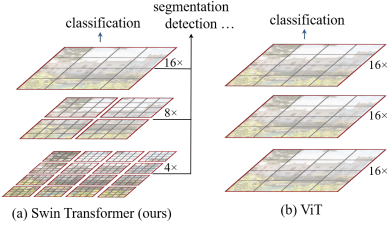

Key differences between Swin Transformer and original Vision Transformer (ViT) model is that ViT produced feature maps of a single low resolution and because it uses a global self-attention ViT has a quadratic computation complexity to input image size. On the other hand, Swin Transformer builds hierarchical feature maps by merging image patches and it has a linear computation complexity to input image size because it uses local windows for calculating selt-attention.


In this tutorial example, we will discuss the different concepts of the Swin Transformers (the name Swin stands for Shifted window) model and implement it in TensorFlow.

## Overview

As described in the paper [arxiv.org](https://arxiv.org/pdf/2103.14030.pdf) and depicted in the following diagram, SWin Transformer works as follows:

- Each image is split into fixed-size patches of size `4 x 4` then passed to a sequence of stages
- The first stage, Calculate a Patch Embeddings for each patch and also the positional embeddings of the patch then add everything together
- The second, third and forth stages starts by merging patches and then passing them through a Swin Transformer block to calculate feature maps
- At eash of those later stages, the number of channels of the patches is multiplied by 2 and the width and height of the images is divided by 2.

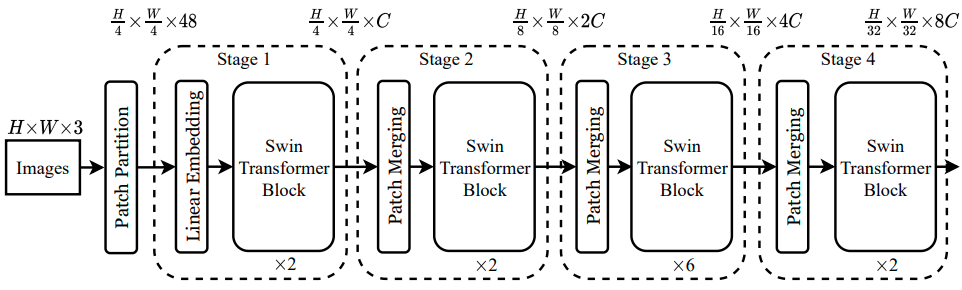

## Implementation

Having built a high level idea of the Swin Transformer Architecture, let's now look at the code-implementation and understand how to implement this architecture in TensorFlow. We will be referencing the code from the [Swin-Transformer-Tensorflow](https://github.com/VcampSoldiers/Swin-Transformer-Tensorflow) repository to explain the implementation. For the PyTorch implementation you can refer to the original implementation of [Swin-Transformer](https://github.com/microsoft/Swin-Transformer).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Softmax

### Patch Partition Layer

The first component of the Swin-T architecture is a Path Parition layer which is used to partition an input image into multiple small patches.

In TensorFlow, we can simply use the [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) function to extract patches. We can use it inside a custom Layer to make it easy to use later when building the model

In [35]:
class PatchPartition(Layer):
    """Partition an image into patches.

    The first component of the Swin-T architecture is a Path Parition layer
    which is used to partition an input image into multiple small patches.

    In TensorFlow, we can simply use the
    [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches)
    function to extract patches. We can use it inside a custom Layer to make it
    easy to use later when building the model
    """

    def __init__(self, window_size: int = 4, channels: int = 3):
        super().__init__()
        self.window_size = window_size
        self.channels = channels

    def call(self, images: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

> Note how similar is this patch extraction layer to the one used in [ViT](https://dzlab.github.io/notebooks/tensorflow/vision/classification/2021/10/01/vision_transformer.html)

We could also use `Conv2d` layer to do the same as a 2-D Convolution uses kernel size (which in our case will be the patch size) and the stride also will be equal to the patch size as we want the windows to not be overlapping.  

Alternatively we can implemnt this using `tf.reshape` like this for instance:

```python
batch, height, width, channels = images.shape
patch_num_x = width // window_size
patch_num_y = height // window_size
new_shape = (-1, patch_num_y, window_size, patch_num_x, window_size, channels)
tf.reshape(images, shape=new_shape)
```

Let's download a test image and make sure it matches the shape of images in the ImageNet dataset.

In [4]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224

(-0.5, 223.5, 223.5, -0.5)

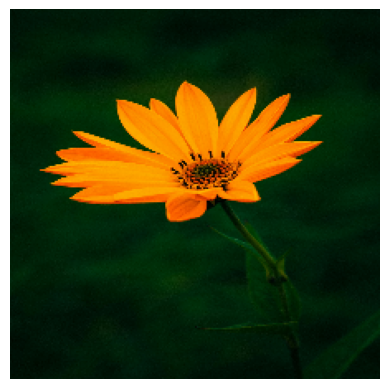

In [5]:
image = plt.imread("flower.jpeg")
image = tf.image.resize(tf.convert_to_tensor(image), size=(224, 224))
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

We can apply the images through our `PatchParition` layer

In [6]:
batch = tf.expand_dims(image, axis=0)
patches = PatchPartition()(batch)
print(patches.shape)

(1, 3136, 48)


Now we can examine the partitions that we just created

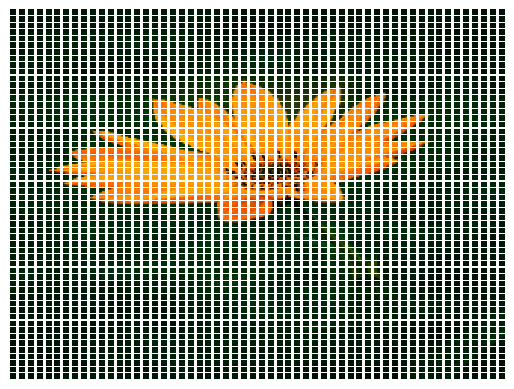

In [7]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (4, 4, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

### Linear Embedding layer
The second component in the Swin-T architecture is the Linear Embedding layer which is simply a combination of projection and embedding layers. It is used to calculate the patch embedding and the position embedding then add both as illustrated with the following diagram

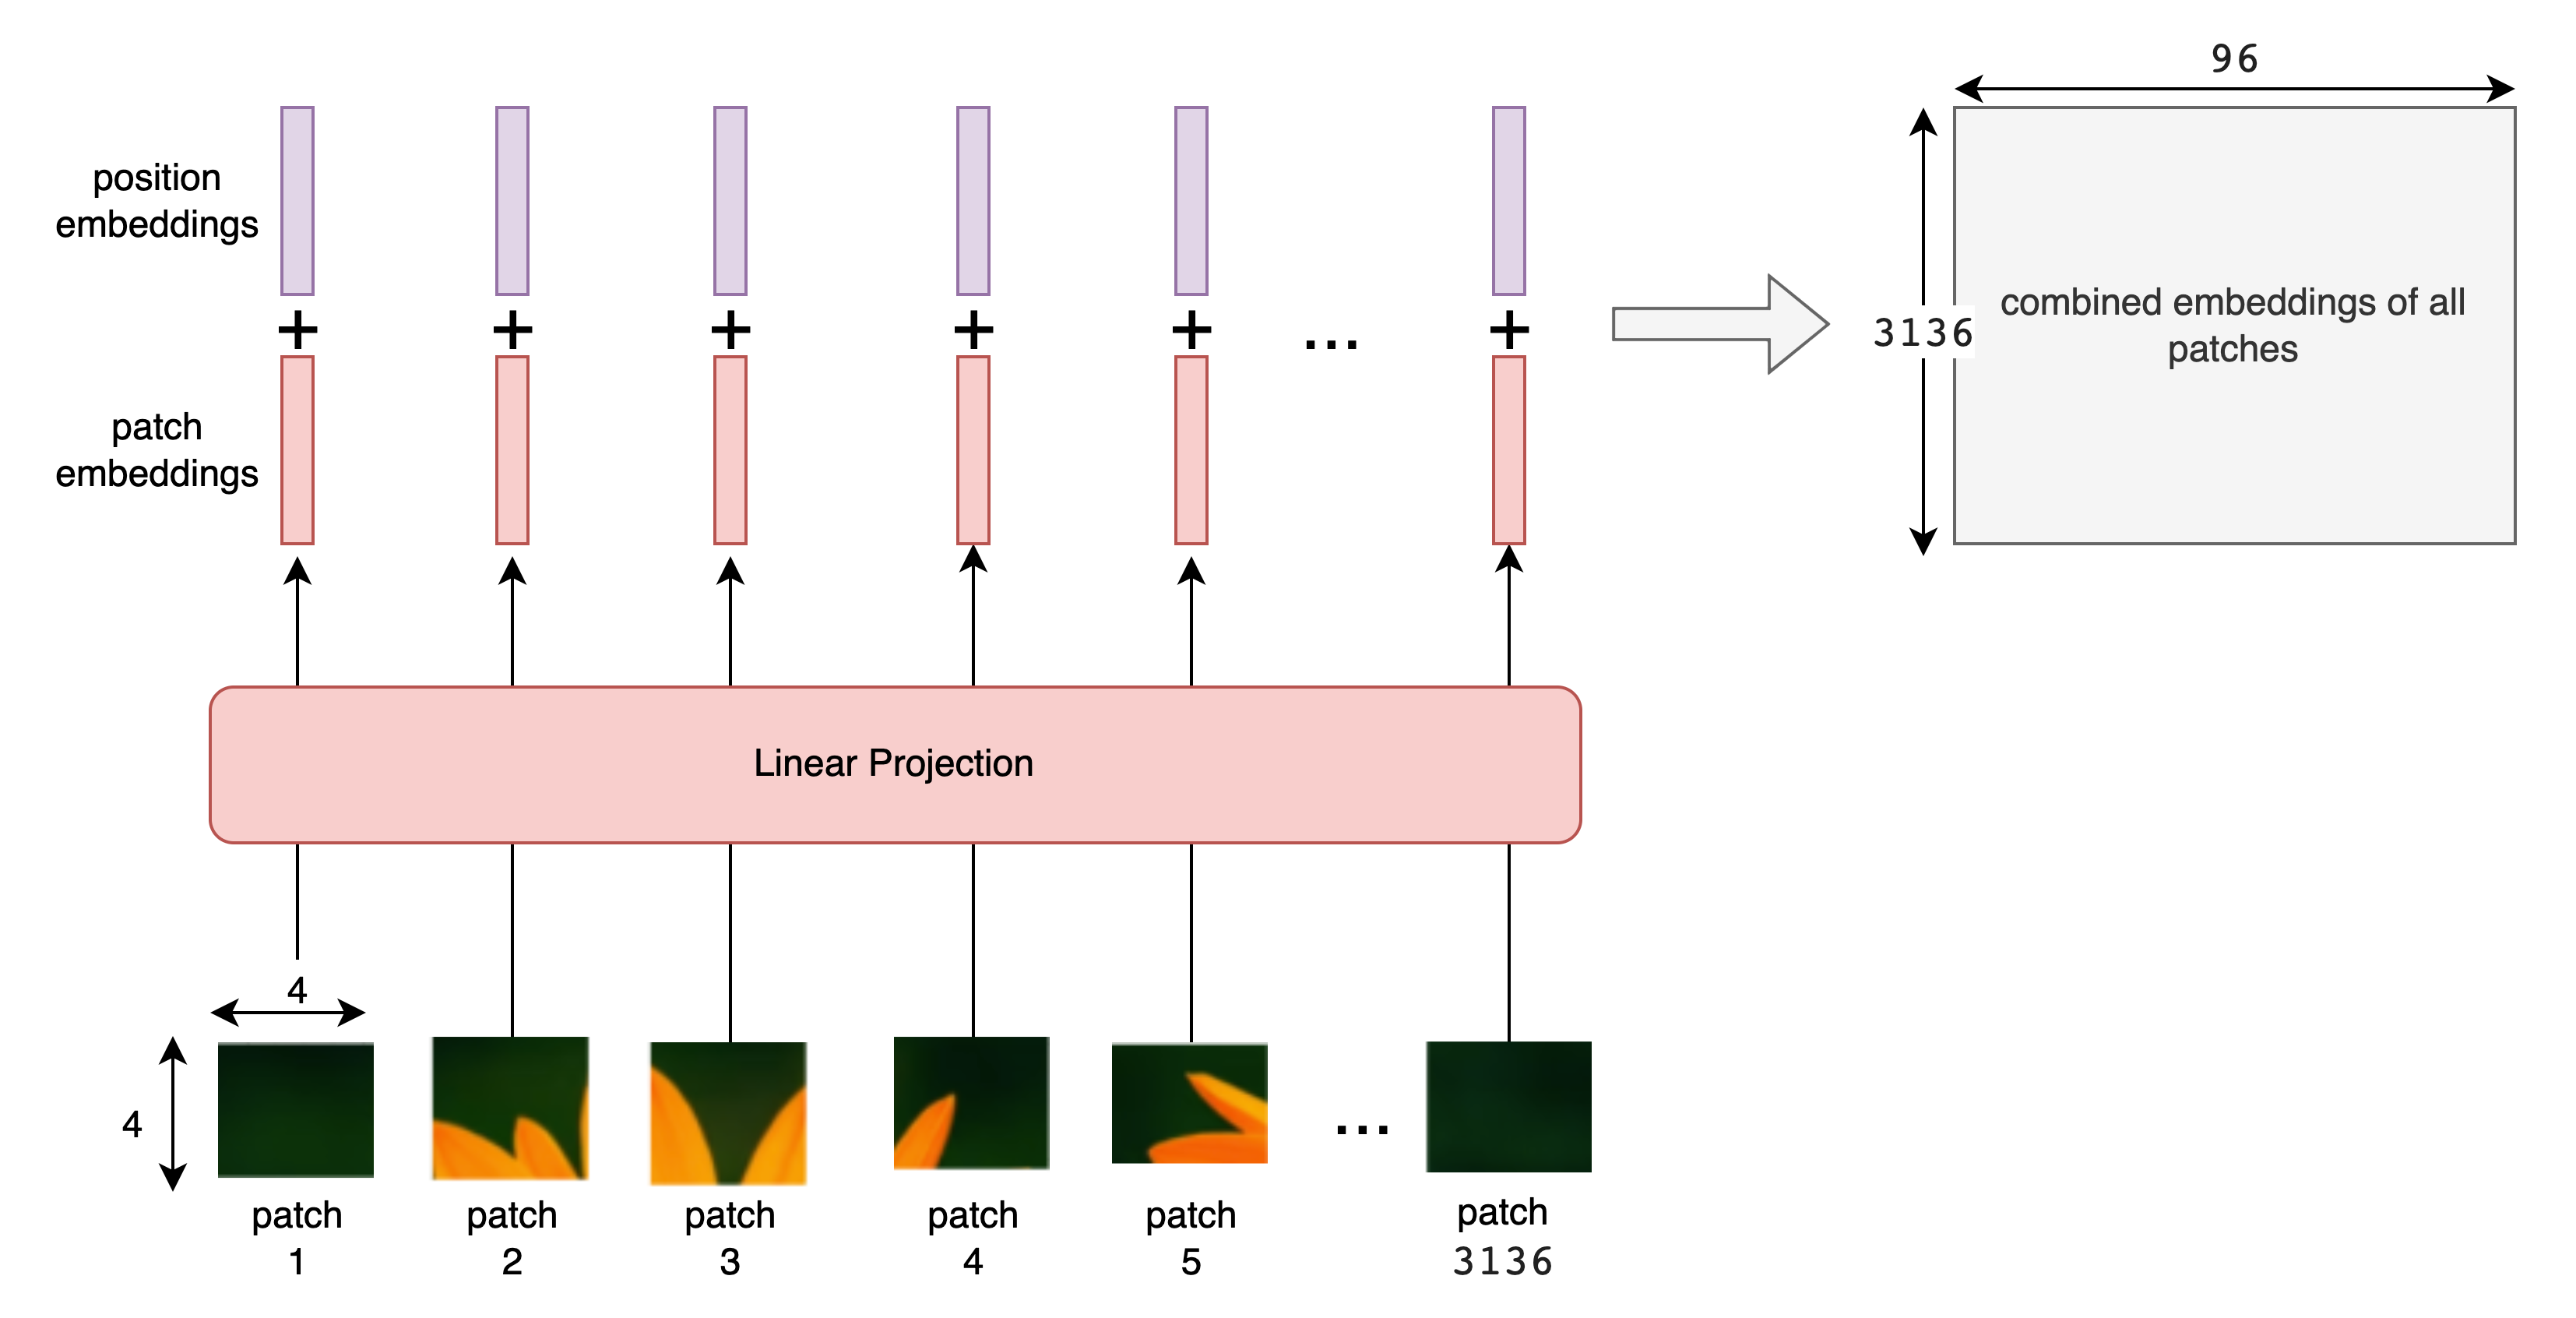

In [8]:
class LinearEmbedding(Layer):
    """Calculate patch and position embedding and add them together.

    The second component in the Swin-T architecture is the Linear Embedding
    layer which is simply a combination of projection and embedding layers.
    It is used to calculate the patch embedding and the position embedding then
    add both as illustrated with the following diagram
    """

    def __init__(self, num_patches: int, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches,
                                            output_dim=projection_dim)

    def call(self, patch: tf.Tensor) -> tf.Tensor:
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

We can confirm that the output of this layer is as expected `1, 3136, 96`
number of patches is `num_patch_x * num_patch_y = 224 / window_size`

In [9]:
embeddings = LinearEmbedding(3136, 96)(patches)
print(embeddings.shape)

(1, 3136, 96)


### Patch Merging layer
Patch merging as it may indicate is used to merge smaller patches into larger ones. Let's look at the illustration to understand what this layer is doing, if the input of the layer is an `8 x 8` pixel image with 4 patches of `4 x 4` then the output becomes an `8 x 8` pixels but with one large patch of `8 x 8` plus an additional channel layer as channel layers are doubled.

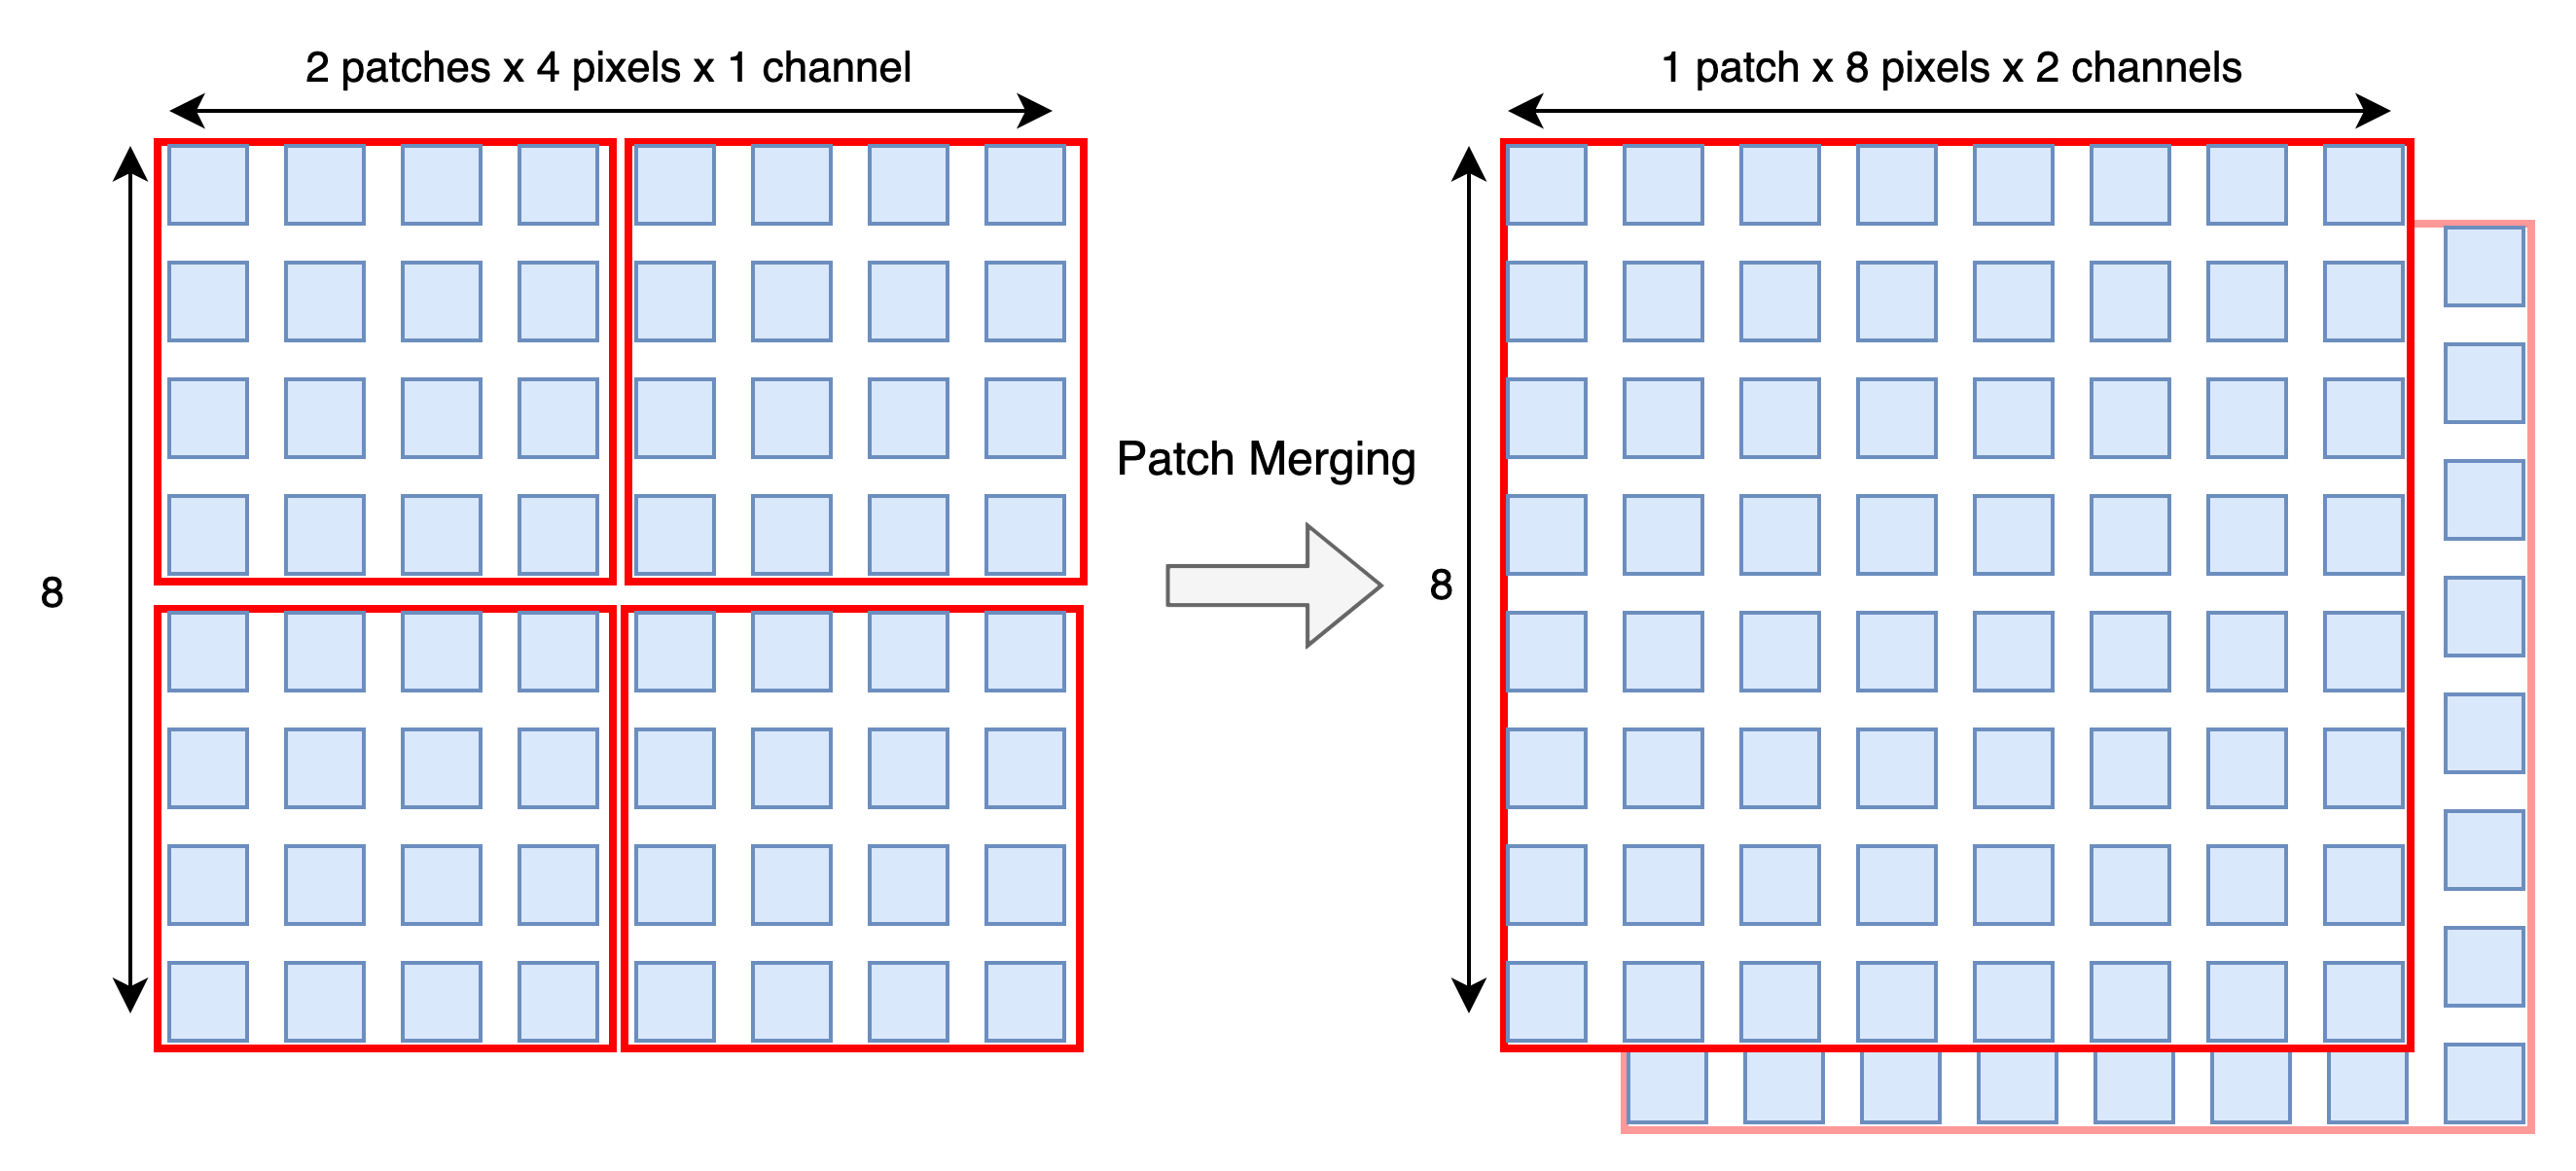

This layer can be simply implemented as a linear layer so that we can easily define the size of the output and double the channels as follows:

In [10]:
class PatchMerging(Layer):
    """Merge smaller patches into larger ones.

    Let's look at the illustration to understand what this layer is doing, if
    the input of the layer is an `8 x 8` pixel image with 4 patches of `4 x 4`
    then the output becomes an `8 x 8` pixels but with one large patch of
    `8 x 8` plus an additional channel layer as channel layers are doubled.

    ![image.png](data:image/png;base64,)

    This layer can be simply implemented as a linear layer so that we can
    easily define the size of the output and double the channels as follows:
    """

    def __init__(self, input_resolution: tuple[int, int], channels: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        height, width = self.input_resolution
        _, _, c = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, c))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * c))
        return self.linear_trans(x)

In [11]:
channels = 96
num_patch_x = 224 // 4
num_patch_y = 224 // 4
out_patches = PatchMerging((num_patch_x, num_patch_y), channels)(patches)
print(f"Input shape (B,   H * W,  C) = {patches.shape}")
print(f"Ouput shape (B, H/2*W/2, 4C) = {out_patches.shape}")

Input shape (B,   H * W,  C) = (1, 3136, 48)
Ouput shape (B, H/2*W/2, 4C) = (1, 784, 192)


### Swin Transfomer block
The Swin Transformer block combines two Transofmer Encoder blocks but uses a window based self-attentions as illustrated in the following diagram. In this section, we will examine each component of this bloc and implement it in TensorFlow

> Note: W-MSA stands for Window Multi-head Self-Attention and SW-MSA stands for Shifted Window Multi-head Self-Attention.

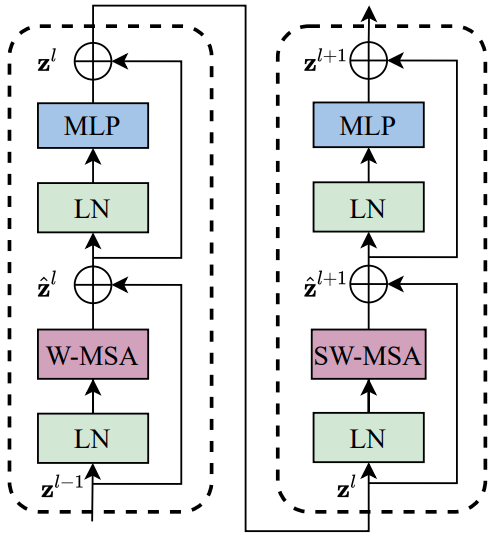

#### Multilayer Perceptron
A Multilayer Perceptron (MLP) consists basically two dense layers and a GELU activation layer. It is used in the classical Transformer architecture and it is also used in the Swin Transformer blocks. We can simply implement it as custom layer as follows:

In [12]:
class MLP(Layer):
    """Multilayer Perceptron (MLP) with GELU activation.

    A Multilayer Perceptron (MLP) consists basically two dense layers and a
    GELU activation layer.
    It is used in the classical Transformer architecture and it is also used in
    the Swin Transformer blocks.
    We can simply implement it as custom layer as follows:
    """

    def __init__(
        self,
        hidden_features: int,
        out_features: int,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [13]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 197, 768)))
print(y.shape)

(1, 197, 768)


#### Window multi-head self-attention
The following implementaiton support boths of shifted and non-shifted window attention.

In [14]:
class WindowAttention(Layer):
    """Support both shifted and non-shifted window attention."""

    def __init__(  # noqa: PLR0913
        self,
        dim: int,
        window_size: tuple[int, int],
        num_heads: int,
        *,
        qkv_bias: bool = True,
        qk_scale: float | None = None,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        initializer = TruncatedNormal(mean=0.0, stddev=0.02)
        # position table shape is: (2*Wh-1 * 2*Ww-1, nH)
        table_shape = (
            (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
            num_heads,
        )
        self.relative_position_bias_table = tf.Variable(
            initializer(shape=table_shape))

        # get pair-wise relative position index for each token inside window
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w))  # 2, Wh, Ww
        coords_flatten = tf.reshape(coords, [2, -1])  # 2, Wh*Ww
        # 2, Wh*Ww, Wh*Ww
        relative_coords = (coords_flatten[:, :, None] -
                           coords_flatten[:, None, :])
        # Wh*Ww, Wh*Ww, 2
        relative_coords = tf.transpose(relative_coords, perm=[1, 2, 0])
        # shift to start from 0
        relative_coords = relative_coords + [
            self.window_size[0] - 1,
            self.window_size[1] - 1,
        ]
        relative_coords = relative_coords * [2 * self.window_size[1] - 1, 1]
        self.relative_position_index = tf.math.reduce_sum(relative_coords,
                                                          -1)  # Wh*Ww, Wh*Ww

        self.qkv = Dense(dim * 3,
                         use_bias=qkv_bias,
                         kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x: tf.Tensor, mask: tf.Tensor | None = None) -> tf.Tensor:
        _, L, N, C = x.shape
        qkv = tf.transpose(
            tf.reshape(self.qkv(x),
                       [-1, N, 3, self.num_heads, C // self.num_heads]),
            perm=[2, 0, 3, 1, 4],
        )  # [3, B_, num_head, Ww*Wh, C//num_head]
        q, k, v = tf.unstack(
            qkv)  # make torchscript happy (cannot use tensor as tuple)
        q = q * self.scale
        attn = tf.einsum("...ij,...kj->...ik", q, k)
        relative_position_bias = tf.reshape(
            tf.gather(
                self.relative_position_bias_table,
                tf.reshape(self.relative_position_index, [-1]),
            ),
            [
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = tf.transpose(relative_position_bias,
                                              perm=[2, 0,
                                                    1])  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias

        if mask is not None:
            nW = mask.shape[0]  # every window has different mask [nW, N, N]
            # add mask: make each component -inf or just leave it
            attn = (tf.reshape(attn, [-1 // nW, nW, self.num_heads, N, N]) +
                    mask[:, None, :, :])
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = tf.reshape(tf.transpose(attn @ v, perm=[0, 2, 1, 3]),
                       [-1, L, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [15]:
attn = WindowAttention(
    96,
    window_size=(4, 4),
    num_heads=8,
    qkv_bias=True,
    qk_scale=None,
    attn_drop=0.0,
    proj_drop=0.0,
)
y = attn(tf.zeros((1, 196, 16, 96)))
print(y.shape)

(1, 196, 16, 96)


#### Helper functions
Before defining the Swin Transformer block, we need couple helper functions to create create windows and merge them

First, `window_partition` which as the name suggest create windows from the input tensor

In [39]:
def window_partition(x: tf.Tensor, window_size: int) -> tf.Tensor:
    """Create windows from the input tensor."""
    _, height, width, channel = x.shape
    num_patch_y = height // window_size
    num_patch_x = width // window_size
    x = tf.reshape(
        x, [-1, num_patch_y, window_size, num_patch_x, window_size, channel])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(
        x, [-1, num_patch_x * num_patch_y, window_size, window_size, channel])
    return windows

In [17]:
windows = window_partition(batch, 4)
print(f"Input shape (B,   H,  W,  C) = {batch.shape}")
print("Ouput shape (num_windows*B, window_size, window_size, C) = "
      f"{windows.shape}")

Input shape (B,   H,  W,  C) = (1, 224, 224, 3)
Ouput shape (num_windows*B, window_size, window_size, C) = (1, 3136, 4, 4, 3)


Second, `window_reverse` which as the name suggest reverse the created windows

In [18]:
def window_reverse(
    windows: tf.Tensor,
    window_size: int,
    height: int,
    width: int,
) -> tf.Tensor:
    """Reverse the created windows."""
    channel = windows.shape[-1]
    batch = int(windows.shape[1] /
                (height * width / window_size / window_size))
    x = tf.reshape(
        windows,
        [
            batch,
            height // window_size,
            width // window_size,
            window_size,
            window_size,
            channel,
        ],
    )
    x = tf.reshape(tf.transpose(x, perm=[0, 1, 3, 2, 4, 5]),
                   [-1, height, width, channel])
    return x

In [19]:
y = window_reverse(windows, 4, 224, 224)
print("Input shape (B, num_windows*B, window_size, window_size, C) = "
      f"{windows.shape}")
print(f"Ouput shape (B, H, W, C) = {y.shape}")

Input shape (B, num_windows*B, window_size, window_size, C) = (1, 3136, 4, 4, 3)
Ouput shape (B, H, W, C) = (1, 224, 224, 3)


In [29]:
class DropPath(Layer):
    """Regularization layer to drop paths in training."""

    def __init__(self, prob: float = 0.0):
        super().__init__()
        self.drop_prob = prob

    def call(self, x: tf.Tensor, *, training: bool | None = None) -> tf.Tensor:
        if self.drop_prob == 0.0 or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0], ) + (1, ) * (x.ndim - 1)
        random_tensor = tf.random.uniform(shape=shape)
        random_tensor = tf.where(random_tensor < keep_prob, 1, 0)
        output = x / keep_prob * random_tensor
        return output

In [30]:
drop = DropPath(0.2)
y = drop(tf.zeros((1, 197, 768)))
print(y.shape)

(1, 197, 768)


#### SwinTransformerBlock
With the shifted window partitioning approach, consecutive Swin Transformer blocks are computed as

In [31]:
class SwinTransformerBlock(Layer):
    """Swin Transformer block with shifted window partitioning."""

    def __init__(  # noqa: PLR0913
        self,
        dim: int,
        input_resolution: tuple[int, int],
        num_heads: int,
        *,
        window_size: int = 7,
        shift_size: int = 0,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        qk_scale: float | None = None,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, don't partition
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, (
            "shift_size must in 0-window_size")

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = (DropPath(drop_path)
                          if drop_path > 0.0 else tf.identity)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            height, width = self.input_resolution
            img_mask = np.zeros([1, height, width, 1])  # 1 H W 1
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(
                img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = tf.reshape(
                mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask == 0, -100.0, 0.0)
        else:
            self.attn_mask = None

    def call(self, x: tf.Tensor) -> tf.Tensor:
        height, width = self.input_resolution
        _, L, C = x.shape
        assert height * width == L, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, [-1, height, width, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x,
                                shift=[-self.shift_size, -self.shift_size],
                                axis=(1, 2))
        else:
            shifted_x = x

        # partition windows
        # shape: nW*B, window_size, window_size, C
        x_windows = window_partition(shifted_x, self.window_size)
        # shape: nW*B, window_size*window_size, C
        x_windows = tf.reshape(
            x_windows,
            [-1, x_windows.shape[1], self.window_size * self.window_size, C],
        )

        # W-MSA/SW-MSA
        attn_windows = self.attn(
            x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = tf.reshape(
            attn_windows,
            [-1, x_windows.shape[1], self.window_size, self.window_size, C],
        )
        # B H' W' C
        shifted_x = window_reverse(attn_windows, self.window_size, height,
                                   width)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x,
                shift=[self.shift_size, self.shift_size],
                axis=(1, 2),
            )
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, height * width, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [32]:
block = SwinTransformerBlock(96, (56, 56), 8, window_size=4)
y = block(embeddings)
print(y.shape)

(1, 3136, 96)


## Putting it together
After defining all the major components of the Swin-T architecture, we can put them together to build the model. This is fairly straightforward now as we just need to plug a window partition to an blocks of Swin Transformers separated by a merging layer. For classification, we add a pooling then a dense layer to the form the head of the model.



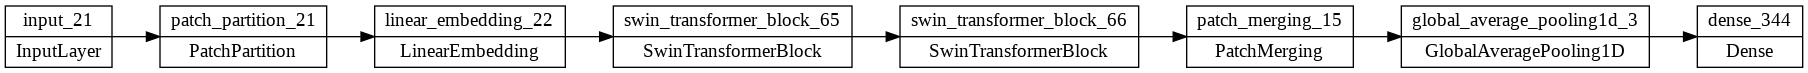

In [36]:
def create_swintransformer(
    num_classes: int,
    *,
    input_shape: tuple[int, int, int] = (224, 224, 3),
    window_size: int = 4,
    embed_dim: int = 96,
    num_heads: int = 8,
) -> Model:
    """Create a Swin Transformer model.

    After defining all the major components of the Swin-T architecture, we can
    put them together to build the model.
    This is fairly straightforward now as we just need to plug a window
    partition to an blocks of Swin Transformers separated by a merging layer.
    For classification, we add a pooling then a dense layer to the form the
    head of the model.

    Note: In our case we are using only one stage of Swin Transformer blocks.
    In the original paper, there are 4 of those stages.
    """
    num_patch_x = input_shape[0] // window_size
    num_patch_y = input_shape[1] // window_size
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchPartition(window_size)(inputs)
    patches_embed = LinearEmbedding(num_patch_x * num_patch_y,
                                    embed_dim)(patches)
    # first Swin Transformer block
    out_stage_1 = SwinTransformerBlock(
        dim=embed_dim,
        input_resolution=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0,
    )(patches_embed)
    # second Swin Transformer block
    out_stage_1 = SwinTransformerBlock(
        dim=embed_dim,
        input_resolution=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=1,
    )(out_stage_1)
    # patch merging
    representation = PatchMerging((num_patch_x, num_patch_y),
                                  channels=embed_dim)(out_stage_1)
    # pooling
    representation = GlobalAveragePooling1D()(representation)
    # logits
    output = Dense(num_classes, activation="softmax")(representation)
    # Create model
    model = Model(inputs=inputs, outputs=output)
    return model

> Note: In our case we are using only one stage of Swin Transformer blocks. In the original paper, there are 4 of those stages.

In [37]:
model = create_swintransformer(2)

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_partition_2 (PatchPartition)   │ (None, None, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ linear_embedding_1 (LinearEmbedding) │ (None, 3136, 96)            │         305,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_block_1             │ (None, 3136, 96)            │         111,840 │
│ (SwinTransformerBlock)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_block_2             │ (None, 3136, 96)            │         111,840 │
│ (SwinTransformerBlock)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_merging_1 (PatchMerging)       │ (None, 784, 192)            │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 192)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 603,554 (2.30 MB)

 Trainable params: 603,554 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Thank you, that's all.